# DSE Course 3, Lab 3: Practice with Dashboards and CNNs

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this lab we will use one of the CNNs we created earlier today to predict the classification for single images. We will then experiment with putting this work flow into a dashboard.

<br>

---




# Import Packages

In [1]:
!pip install jupyter-dash

!pip install dash_daq

     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 1.0MB 11.7MB/s 
     |████████████████████████████████| 3.5MB 30.9MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
     |████████████████████████████████| 1.8MB 37.5MB/s 
     |████████████████████████████████| 358kB 37.3MB/s 
  Created wheel for dash: filename=dash-1.20.0-cp37-none-any.whl size=85845 sha256=3a4b8becaa635799318c7ee11798759df61c34d016b8e7c6c710535d01beeab0
  Stored in directory: /root/.cache/pip/wheels/e6/33/41/ce361d0d1da277d2350f815b10f2ab1e331592d93ef2b07e29
  Created wheel for dash-renderer: filename=dash_renderer-1.9.1-cp37-none-any.whl size=1014873 sha256=409cfa53658cc93a30606095c82ae363d4287e4b91be4202ef94cfe102166d6c
  Stored in directory: /root/.cache/pip/wheels/03/a9/c5/dd5815c601b0ede164c223ffd7bafebde716ca57de06ef8aec
  Created wheel for dash-core-components: filename=dash_core_components-1.16.0-cp37-none-any.whl size=3540992 sha256=8bab928e76a88807592215

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import base64

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_daq as daq

from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

#importing required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Load Dataset / Model

In [3]:
# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Point to where you have your model from earlier today saved:

In [4]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/drive/MyDrive/ds_for_engineers/courses/C3: Leverage Your Model/DATA/inspection_of_casting_products.h5")

As well as to where you have your casting data saved:

In [5]:
path_to_casting_data = '/content/drive/MyDrive/ds_for_engineers/data/casting_defects/casting_data_class_practice/'
technocast_train_path = path_to_casting_data + 'train/'
image_path = technocast_train_path + '/ok_front/cast_ok_0_1.jpeg'

(300, 300, 3)


(-0.5, 299.5, 299.5, -0.5)

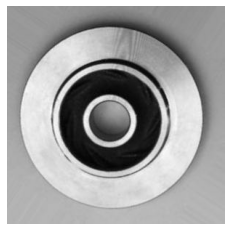

In [6]:
# tensorflow
img = tf.io.read_file(image_path)
img = tf.io.decode_jpeg(img)

# drop the extra channel (3d squeezed into 2d, rgb to intensity/gray)
print(tf.squeeze(img).shape)
plt.imshow(tf.squeeze(img), cmap='gray', vmin=0, vmax=255)
plt.axis('off')

# L3 Q1: Test the Model

Feed a single image (like the one above) into your model and print out the outcome of the prediction

In [7]:
# Code Cell for L1 Q1
image = tf.image.rgb_to_grayscale(img)
image = tf.expand_dims(image, axis=0)

prediction = model.predict(image) > 0.5
print(prediction[0][0])

True


# L3 Q2: Create the Layout

First let's create a layout, nothing fancy. The main new element we'll be working with is [`dcc.Upload`](https://dash.plotly.com/dash-core-components/upload)

To get you started on the `dcc.Upload` component, there are 4 parameters I want you to set:

* `id` - give it some unique id, like 'upload-id'
  * it may seem pedestrian but I like to put id in the name because it  helps me remember that it is an id parameter when I want to reference it elsewhere in the application
* `children` - this is where you will put the text that will display on the upload button. Here I'm going to just give you the text to display:
```
children = html.Div
        ([
          'Drag and Drop or ',
          html.A('Select Files')
        ]),
```
* `style` - style will give a nice border to the button. Here as well just use this as the style parameter:
```
        style={
            'width': '50%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
```
* `multiple` - a boolean value. If you want to allow your user to upload multiple files at once set to True


In [11]:
# Code Cell for L1 Q2

# this will make it pretty
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# include the stylesheet when declaring the model
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
  [
   ### YOUR CODE HERE ###
   # use html.H1 to make a nice header
   # add your dcc.Upload component
  html.H1(['Product Defect Detection']),
  dcc.Upload(
      id='upload-id',
      children = html.Div
        ([
          'Drag and Drop or ',
          html.A('Select Files')
        ]),
        style={
            'width': '50%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        multiple=True,
  )

  ]
  )
                  
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# L3 Q3: Create Callback

Next, we'll add a callback that takes our `dcc.Upload` component as input, and create a new `html.Div` in the layout that will be updated with the contents. We'll leave the `parse_contents()` function empty for now, just to see if our callback works!

* **`@app.callback`** - There's three pieces of data we can strip from `dcc.Upload` the file, the filename, and the file last save date. For now, we're only going to worry about parsing the file. Your callback formula will look something like:

```
@app.callback(Output('YOUR NEW HTML.DIV ID', 'children'),
              Input('<YOUR DCC.UPLOAD ID>', 'contents'))
def update_output(list_of_contents):
    # RETURN A LIST OF PROCESSED FILES TO THE HTML.DIV
    children = [
        parse_contents(contents) for contents in list_of_contents]
    return children
```

In this formula we are saying, take the contents of our `dcc.Upload`, process each of them with a new function we will write called `parse_contents` and return this list of parsed files to `html.Div`, where they will be displayed on the screen. 

* **`html.Div`** - In order to use this callback you'll need to create a new `html.Div` element on your dashboard called `'<something-nice-and-clever'`. Do so at the bottom of your layout.

* **`parse_contents`** - In addtion, we'll need to create a new function called `parse_contents`, do this as well. It will take in the file contents and for now, just return the file contents (i.e. it won't do anything right now)

In [16]:
# Code Cell for L1 Q2

# this will make it pretty
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# include the stylesheet when declaring the model
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
  [
   ### YOUR CODE HERE ###
   # use html.H1 to make a nice header
   # add your dcc.Upload component
  html.H1(['Product Defect Detection']),
  dcc.Upload(
      id='upload-id',
      children = html.Div
        ([
          'Drag and Drop or ',
          html.A('Select Files')
        ]),
        style={
            'width': '50%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        multiple=True,
  ),
   ###  YOUR NEW HTML.DIV ELEMENT HERE ###
   html.Div(id='output-image-upload'),

  ]
  )

### YOUR PARSE_CONTENTS FUNCTION ###
def parse_contents(contents):
  return contents

### YOUR CALLBACK HERE ###
@app.callback(Output('output-image-upload', 'children'),
              Input('upload-id', 'contents'))
def update_output(list_of_contents):
    children = [
        parse_contents(c) for c in list_of_contents]
    return children
                  
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# L3 Q4: Create Parse Function

Now its time for some machine learning. Are you ready? I'm ready. 

This part can get confusing. The datatype that is returned by dcc.Upload when it processes images is a base64 encoding, but it has some metadata put at the front end of it. You can see this if you play around with uploading an image file in `Q3` and look at the print out to the screen: `data:image/jpeg;base64,/9j/4AAQSkZJRgABA...` We will want to cut off everything before the `,` and process what comes after with `base64.b64decode()` after this tensorflow can decode the resultant object with `tf.io.decode_image()` So your code will look something like:
```
content_type, content_string = contents.split(',')
decoded = base64.b64decode(content_string)
img = tf.io.decode_image(decoded)
```
After you've processed your image, continue with the procedure you did in Q1 and run your image through the predictive model, then return to the screen a nice readout of what just took place. By the way, you can display the image with a html component like so:
```
html.Img(src=contents),
```
Lastly, don't forget that the return of the `parse_contents` function should be dash component, for example `html.Div([])` with other components nested inside, should you want to display multiple things.



In [19]:
# Code Cell for L1 Q2

# this will make it pretty
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

# include the stylesheet when declaring the model
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
  [
   ### YOUR CODE HERE ###
   # use html.H1 to make a nice header
   # add your dcc.Upload component
  html.H1(['Product Defect Detection']),
  dcc.Upload(
      id='upload-id',
      children = html.Div
        ([
          'Drag and Drop or ',
          html.A('Select Files')
        ]),
        style={
            'width': '50%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        multiple=True,
  ),
   ###  YOUR NEW HTML.DIV ELEMENT HERE ###
   html.Div(id='output-image-upload'),

  ]
  )

### YOUR PARSE_CONTENTS FUNCTION ###
def parse_contents(contents):
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    img = tf.io.decode_image(decoded)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.expand_dims(img, axis=0)
    prediction = model.predict(img) > 0.5
    prediction = str(prediction[0][0])
    
    return html.Div([
          html.Img(src=contents),
          html.Hr(),
          html.Div('Product Passing?'),
          html.Pre(prediction, style={
              'whiteSpace': 'pre-wrap',
              'wordBreak': 'break-all'
          })
    ])

### YOUR CALLBACK HERE ###
@app.callback(Output('output-image-upload', 'children'),
              Input('upload-id', 'contents'))
def update_output(list_of_contents):
    children = [
        parse_contents(c) for c in list_of_contents]
    return children
                  
app.run_server(mode='inline')

<IPython.core.display.Javascript object>